In [ ]:
import os
os.chdir(r'4 - Transformer')
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import chain
from itertools import groupby
from functools import reduce
from typing import Collection, List
from pathlib import Path
import music21 as m21
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)
from midi_encoding import *

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

In [ ]:
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name()}.")

In [ ]:
vocab = MusicVocab()
vocab.size

In [4]:
vg_large_path = Path('../data/midi/vg_large')
vg_large_file_names = [f for f in os.listdir(vg_large_path) if os.path.isfile(os.path.join(vg_large_path, f))]
len(vg_large_file_names)

3839

### Data loading

Previously we used a fixed context window to split out data into blocks, e.g. 'if we see this block of 8 tokens, what is the ninth?'.

That meant we always had to init the generation with an entire block of context, mostly made of padding. We also needed to add these 'padding init' blocks to training so that the network had seen them before inference time.

Now that we are working with transformers, we will take each block and split it into samples of varying lengths, e.g.

Data - (1, 2, 3, 4)

X(1) -> Y(2)

X(1,2) -> Y(3)

X(1,2,3) -> Y(4)

Because we are going to drastically scale up our block size, it is no longer feasible to pre-block encode the data as every token is duplicated up to block size.

We will need to load a single 1D tensor, then randomly indexes into it to choose a block.

This does mean that at boundaries we will have blocks of performances overlapping (i.e. there will be blocks with a token *after* `<|eos|>`), but hopefully the network will realise that data before and after is correlated.

Alternatively, we could try re-sampling if we get a block with `<|eos|>` anywhere other than the end?

In this notebook we are going to encode the entire dataset at once and *then* split into train / test / validation data, rather than first split by filenames, because it occured to me that the MIDI tracks might have very different lengths.


### Labels

Because we are training every position in the sequence at once, we need a block of labels for each block of data.

This is just the next block in the array (i.e. `X[1]` is the labels for `X[0]`, and `X[2]` is the labels for `X[1]` etc etc), so there is no point in encoding them separately.

### Position

We are going to need to add positional encodings to our data.

Transformers employ a position embedding layer to distinguish between positions in a sequence.

In addition to this, we want to create embeddings for the bar and beat.

These can all be added together to get a hybrid 'position' vector.

To allow us to calculate the bar and beat we need the absolute position of each token, which we can encode at the same time as the batches.

> See `sparse_to_position_enc` - this is where we throw away timestep info, so we now 'snaphot' tidx and package alongside the token values.

In [5]:
def idx_encode(file_names):
    # We can't shuffle the blocks afterwards as we rely on them being contiguous in order to get the targets
    # If we didn't shuffle at all then the train and test splits would contain specific game soundtracks rather than a mixture
    random.shuffle(file_names)
    xs = []
    for file_name in file_names:
        file_path = Path(vg_large_path, file_name)
        idx_score = midifile_to_idx_score(file_path, vocab, False)
        if idx_score is not None: # Files which aren't 4/4 are ignored
            xs.append(idx_score)
    return np.concat(xs) # concat scores to create 1D tensor

def load_or_create(file_names, sample_path):
    if sample_path.exists():
        xs = np.load(sample_path, allow_pickle=True)
    else:
        xs = idx_encode(file_names)
        np.save(sample_path, xs)

    return torch.tensor(xs, device=device)

vg_large_samples_path = Path(f'../data/numpy/vg_large/samples_with_position_all.npy')

data = load_or_create(vg_large_file_names, vg_large_samples_path)

data.shape

torch.Size([8781624, 2])

In [6]:
X = data[0:-1]
Y = data[1:, 0] # Drop position from Y
# Y = data[1:]

In [7]:
X[:12]

tensor([[  0,   0],
        [ 46,   0],
        [138,   0],
        [  3,   0],
        [138,   0],
        [ 45,   6],
        [134,   6],
        [  3,   6],
        [134,   6],
        [ 44,   8],
        [138,   8],
        [  3,   8]], device='cuda:0')

In [8]:
X[-12:]

tensor([[  69, 1356],
        [ 136, 1356],
        [   3, 1356],
        [ 136, 1356],
        [  80, 1360],
        [ 135, 1360],
        [  68, 1360],
        [ 135, 1360],
        [  61, 1360],
        [ 135, 1360],
        [  49, 1360],
        [ 135, 1360]], device='cuda:0')

In [9]:
vocab.to_tokens(X[:, 0][:12])
# vocab.to_tokens(X[:][:12])

'<|sos|> n42 d6 <|sep|> d6 n41 d2 <|sep|> d2 n40 d6 <|sep|>'

In [10]:
vocab.to_tokens(Y[:12])

'n42 d6 <|sep|> d6 n41 d2 <|sep|> d2 n40 d6 <|sep|> d6'

In [11]:
vocab.to_tokens(X[:, 0][-12:])
# vocab.to_tokens(X[:][-12:])

'n65 d4 <|sep|> d4 n76 d3 n64 d3 n57 d3 n45 d3'

In [12]:
vocab.to_tokens(Y[-12:])

'd4 <|sep|> d4 n76 d3 n64 d3 n57 d3 n45 d3 <|eos|>'

We are now ready to build a decoder-only transformer with positional embeddings.

We will start by creating simple custom PyTorch modules following Karpathy in order to fully understand the architecture.

In [13]:
n_embed = 384 # /6 heads = 64 per head
block_size = 256
dropout = 0.2

class SelfAttentionHead(torch.nn.Module):

    def __init__(self, head_size):
        super().__init__()
        self.key = torch.nn.Linear(n_embed, head_size, bias=False)
        self.query = torch.nn.Linear(n_embed, head_size, bias=False)
        self.value = torch.nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        
        # Key - What it offers
        k = self.key(x) # (B, T, C)

        # Query - What it looks for
        q = self.query(x) # (B, T, C)

        # Attention scores
        w = q @ k.transpose(-2, -1) * C ** -0.5 # i.e. math.sqrt(self.embed_size). (B, T, C) @ (B, C, T) -> (B, T, T)

        w = w.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T) Mask the future positions 
        w = F.softmax(w, dim=-1) # (B, T, T)
        w = self.dropout(w)

        # Value - What it has to communicate
        v = self.value(x) # (B, T, C)
        
        # Scale the values by the attention weights
        return w @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
    
class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_heads, head_size):
        super().__init__()
        self.heads = torch.nn.ModuleList([SelfAttentionHead(head_size) for _ in range(n_heads)])
        self.proj = torch.nn.Linear(n_heads * head_size, n_embed) 
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        # Concat over the channel dimension
        out = torch.cat([h(x) for h in self.heads], dim=-1) # Could all be done in parallel by adding a head dimension
        out = self.proj(out)
        return self.dropout(out)
    
class FeedForward(torch.nn.Module):

    def __init__(self, n_embed):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_embed, 4 * n_embed), # 4x is a common expansion factor
            torch.nn.ReLU(),
            torch.nn.Linear(4 * n_embed, n_embed), # Project back to the residual stream
            torch.nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)
    
class Block(torch.nn.Module):

    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.self_attn = MultiHeadAttention(n_head, head_size)
        self.ff = FeedForward(n_embed)
        self.layer_norm1 = torch.nn.LayerNorm(n_embed)
        self.layer_norm2 = torch.nn.LayerNorm(n_embed)

    def forward(self, x):
        # Residual connections
        x = x + self.self_attn(self.layer_norm1(x))
        x = x + self.ff(self.layer_norm2(x))
        return x

In [14]:
max_bar_position = 1024 # 4 beats per bar = 4096 beats, which at 120bpm is 34 minutes. This will hopefully be enough for any song in the training set.
n_head = 6
n_layer = 6

class DecoderTransformer(torch.nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding = torch.nn.Embedding(vocab_size, n_embed)
        self.positional_embedding = torch.nn.Embedding(block_size, n_embed)
        self.beat_embedding = torch.nn.Embedding(SAMPLES_PER_BAR, n_embed)
        self.bar_embedding = torch.nn.Embedding(max_bar_position, n_embed)
        self.blocks = torch.nn.Sequential(*[Block(n_embed, n_head) for _ in range(n_layer)])
        self.layer_norm = torch.nn.LayerNorm(n_embed)
        self.lm_head = torch.nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):

        B, T, E = idx.size()

        # Could split these out in one go using the unbind function
        token_idx = idx[:, :, 0] # (B,T)
        time_idx = idx[:, :, 1] # (B,T)

        sample_idx = time_idx % SAMPLES_PER_BAR # (B,T)
        bar_idx = (time_idx // SAMPLES_PER_BAR) % max_bar_position # (B,T)

        token_embed = self.token_embedding(token_idx) # (B,T,Embed)
        pos_embed = self.positional_embedding(torch.arange(T, device=device)) # (T,Embed)
        bar_embed = self.bar_embedding(bar_idx) # (B,T,Embed)
        sample_embed = self.beat_embedding(sample_idx) # (B,T,Embed)
        
        x = token_embed + pos_embed + bar_embed + sample_embed
        x = self.blocks(x)
        x = self.layer_norm(x)

        if targets is None:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None
        else:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # Flatten all the batches
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens=1024, temperature=1.0):
        self.eval()
        
        B, T, C = idx.size()
        # print(f'idx: {idx.size()}')

        dur_start, _ = vocab.duration_range
        
        for _ in range(max_new_tokens):

            # Get the second to last note index if it exists, otherwise return pad idx
            if idx.size(1) > 1:
                second_to_last_nidx = idx[:, -2, 0].unsqueeze(0) # (B, 1)
            else:
                second_to_last_nidx = torch.stack([torch.tensor([vocab.pad_idx], device=device) for _ in range(B)], dim=0)

            # print(f'second_to_last_nidx: {second_to_last_nidx.size()}')
            
            # Could probably use unbind here
            last_nidx = idx[:, -1, 0] # (B, 1)
            # print(f'last_nidx: {last_nidx.size()}')
            last_tidx = idx[:, -1, 1] # (B, 1)
            # print(f'last_tidx: {last_tidx.size()}')

            # If two tokens ago was a separator, the last token was a time-incrementing duration
            duration_mask = second_to_last_nidx == vocab.sep_idx # (B, 1)

            # Offset the duration idx to get the actual duration, and zero out if the previous token was not a separator
            t_inc = (last_nidx - dur_start) * duration_mask
            # print(f't_inc: {t_inc.size()}')

            # Increment the time index by the duration
            tidx_next = last_tidx + t_inc # (B, 1)
            # print(f'tidx: {tidx_next.size()}')

            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]

            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)

            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature

            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)

            # sample from the distribution
            nidx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # print(f'nidx: {nidx_next.size()}')

            # Concat with the time index
            idx_next = torch.cat((nidx_next, tidx_next), dim=1).unsqueeze(0) # (B, C)
            # print(f'idx_next: {idx_next.size()}')

            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1, C)

        self.train()
        return idx

In [15]:
model = DecoderTransformer(vocab_size=vocab.size)

print(sum(p.numel() for p in model.parameters()))

11445896


In [16]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
token_embedding.weight 	 torch.Size([392, 384])
positional_embedding.weight 	 torch.Size([256, 384])
beat_embedding.weight 	 torch.Size([32, 384])
bar_embedding.weight 	 torch.Size([1024, 384])
blocks.0.self_attn.heads.0.tril 	 torch.Size([256, 256])
blocks.0.self_attn.heads.0.key.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.0.query.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.0.value.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.1.tril 	 torch.Size([256, 256])
blocks.0.self_attn.heads.1.key.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.1.query.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.1.value.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.2.tril 	 torch.Size([256, 256])
blocks.0.self_attn.heads.2.key.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.2.query.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.2.value.weight 	 torch.Size([64, 384])
blocks.0.self_attn.heads.3.tril 	 torch.Size(

In [17]:
batch_size = 128
eval_iters = 100
learning_rate = 3e-2

model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

n_split = int(len(data) * 0.9)
train_data, val_data = data[:n_split], data[n_split:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1, 0] for i in ix])
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [18]:
model_load_path = Path('../data/model/midi_transformer_pos_5.tar')
model_save_path = Path('../data/model/midi_transformer_pos_5.tar')

average_log_losses = {
    "train" : [],
    "val" : []
}

def save_checkpoint(iter):
    losses = estimate_loss()
    train_loss = losses['train']
    val_loss = losses['val']
    average_log_losses['train'].append(train_loss.log10().item())
    average_log_losses['val'].append(val_loss.log10().item())
    print(f'Iteration {iter}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save({
        'iter': iter,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': average_log_losses,
    }, model_save_path)

In [19]:
eval_interval = 500
iterations = 1015500
start_iter = 0

if model_load_path.exists():
    checkpoint = torch.load(model_load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    average_log_losses = checkpoint['losses']
    iter = checkpoint['iter']
    start_iter = iter + 1
    print(f"Loaded model from iteration {iter}")


Loaded model from iteration 1015500


In [20]:
model.train()

remaining_iters = iterations - start_iter
if remaining_iters != -1:
    for iter in range(remaining_iters):

        offset_iter = iter + start_iter
        if offset_iter % eval_interval == 0:
            save_checkpoint(offset_iter)

        # Configure minibatch
        Xb, Yb = get_batch('train')

        # Forward pass
        logits, loss = model(Xb, Yb)

        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    save_checkpoint(iterations)

In [21]:
print('Final training loss:', 10 ** average_log_losses['train'][-1])

Final training loss: 1.1451051189819628


In [22]:
print('Final validation loss:', 10 ** average_log_losses['val'][-1])

Final validation loss: 1.1978368688964853


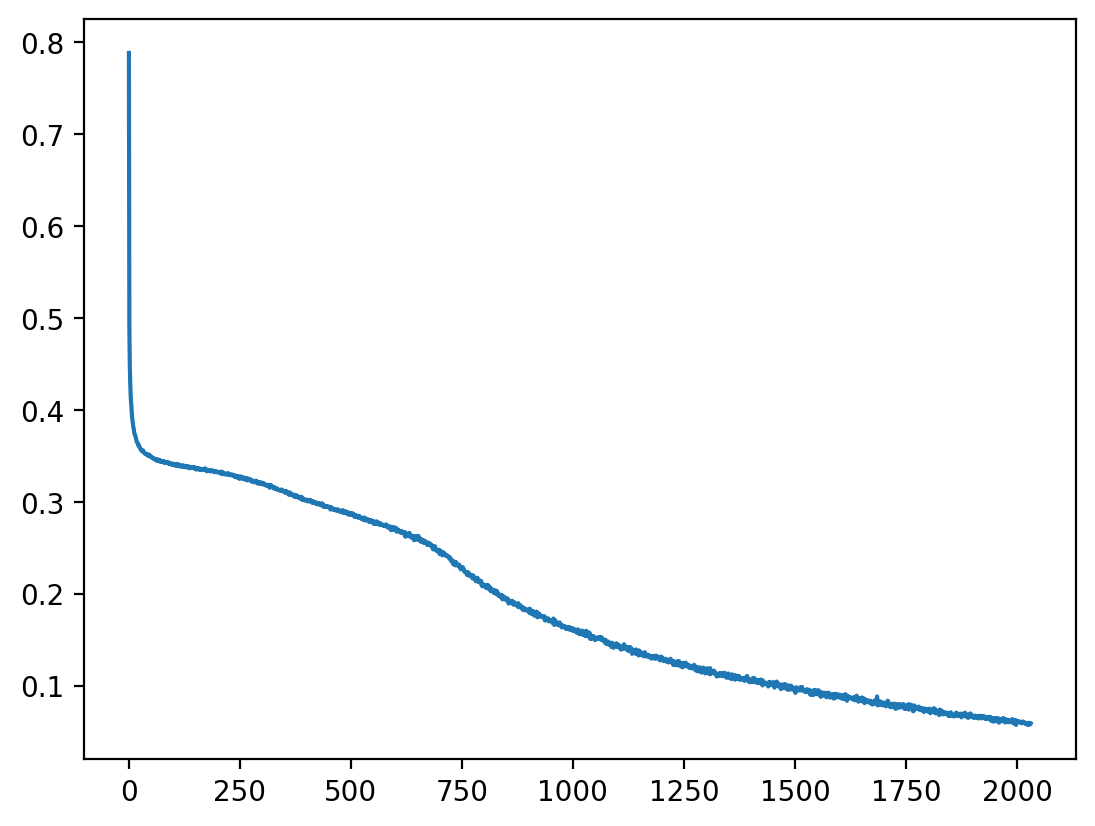

In [23]:
plt.plot(average_log_losses['train'])

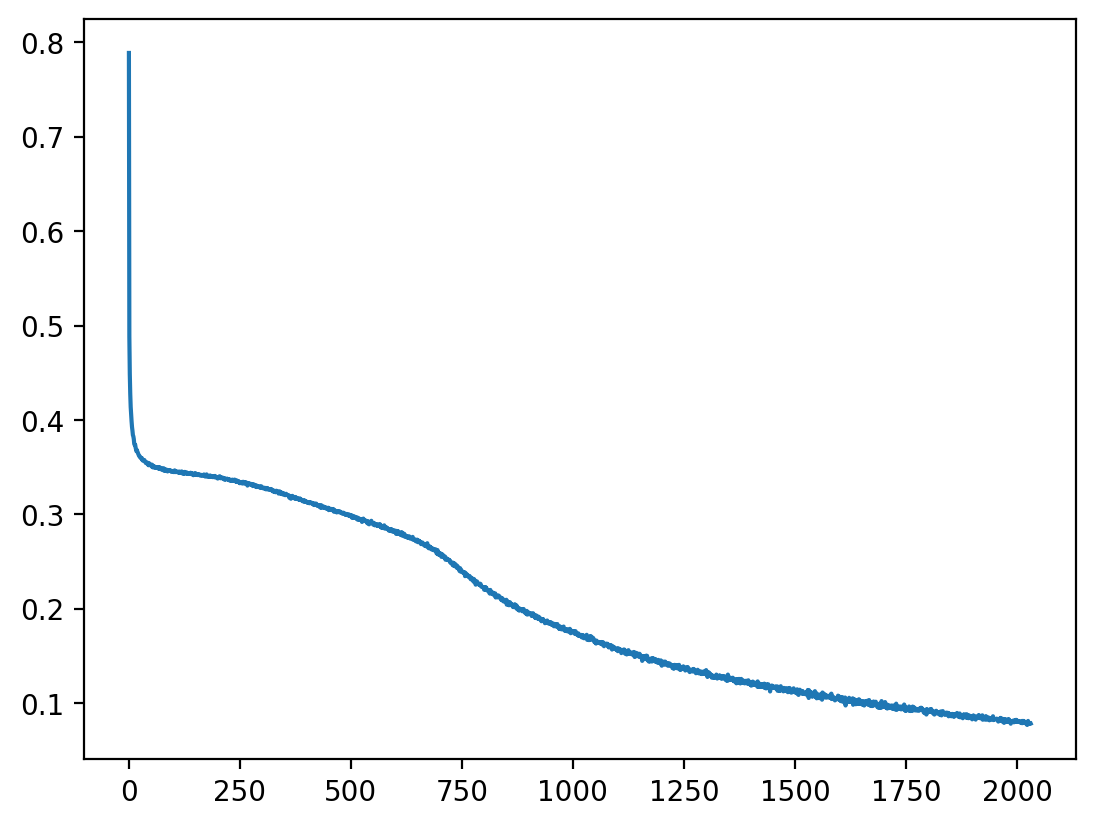

In [24]:
plt.plot(average_log_losses['val'])

In [25]:
init_idx = torch.zeros((1,1,2), dtype=torch.long, device=device)
generated_tokens = model.generate(init_idx, max_new_tokens=512).cpu()


In [26]:
generated_tokens.shape

torch.Size([1, 513, 2])

In [27]:
score = generated_tokens[0, :, 0]
vocab.to_tokens(score)

'<|sos|> n72 d4 n55 d32 n48 d16 <|sep|> d8 n73 d4 n67 d8 <|sep|> d8 n71 d8 n67 d4 n62 d16 <|sep|> d4 n52 d12 <|sep|> d4 n79 d4 n67 d8 n48 d6 <|sep|> d8 n76 d4 n48 d16 <|sep|> d8 n76 d4 n67 d8 <|sep|> d8 n76 d4 n64 d16 n48 d6 <|sep|> d8 n77 d4 n67 d8 n48 d6 <|sep|> d8 n79 d4 n71 d4 n47 d16 <|sep|> d4 n72 d4 n64 d4 <|sep|> d4 n74 d4 n69 d8 <|sep|> d8 n76 d8 n68 d8 n52 d16 <|sep|> d8 n77 d4 n67 d8 n47 d6 <|sep|> d8 n76 d5 n72 d5 n67 d5 n48 d16 <|sep|> d5 n74 d3 <|sep|> d3 n74 d4 n69 d4 n67 d8 n48 d6 <|sep|> d8 n72 d4 n69 d4 n64 d4 n48 d13 <|sep|> d8 n79 d4 n67 d4 n62 d4 n48 d8 <|sep|> d8 n81 d4 n74 d4 n48 d4 <|sep|> d8 n91 d4 n79 d4 n67 d4 n48 d4 <|sep|> d8 n81 d4 n74 d4 n69 d4 n48 d4 <|sep|> d8 n79 d4 n74 d4 n69 d4 n57 d4 n48 d4 <|sep|> d8 n86 d4 n74 d4 n47 d4 <|sep|> d8 n67 d4 <|sep|> d8 n88 d4 n81 d4 n69 d4 n50 d4 <|sep|> d8 n88 d4 n81 d4 n76 d4 n69 d4 <|sep|> d8 n65 d4 n45 d4 <|sep|> d8 n88 d4 n65 d4 n65 d4 <|sep|> d8 n64 d4 n52 d4 <|sep|> d8 n64 d4 n60 d4 n48 d4 <|sep|> d8 n86 d4 n76

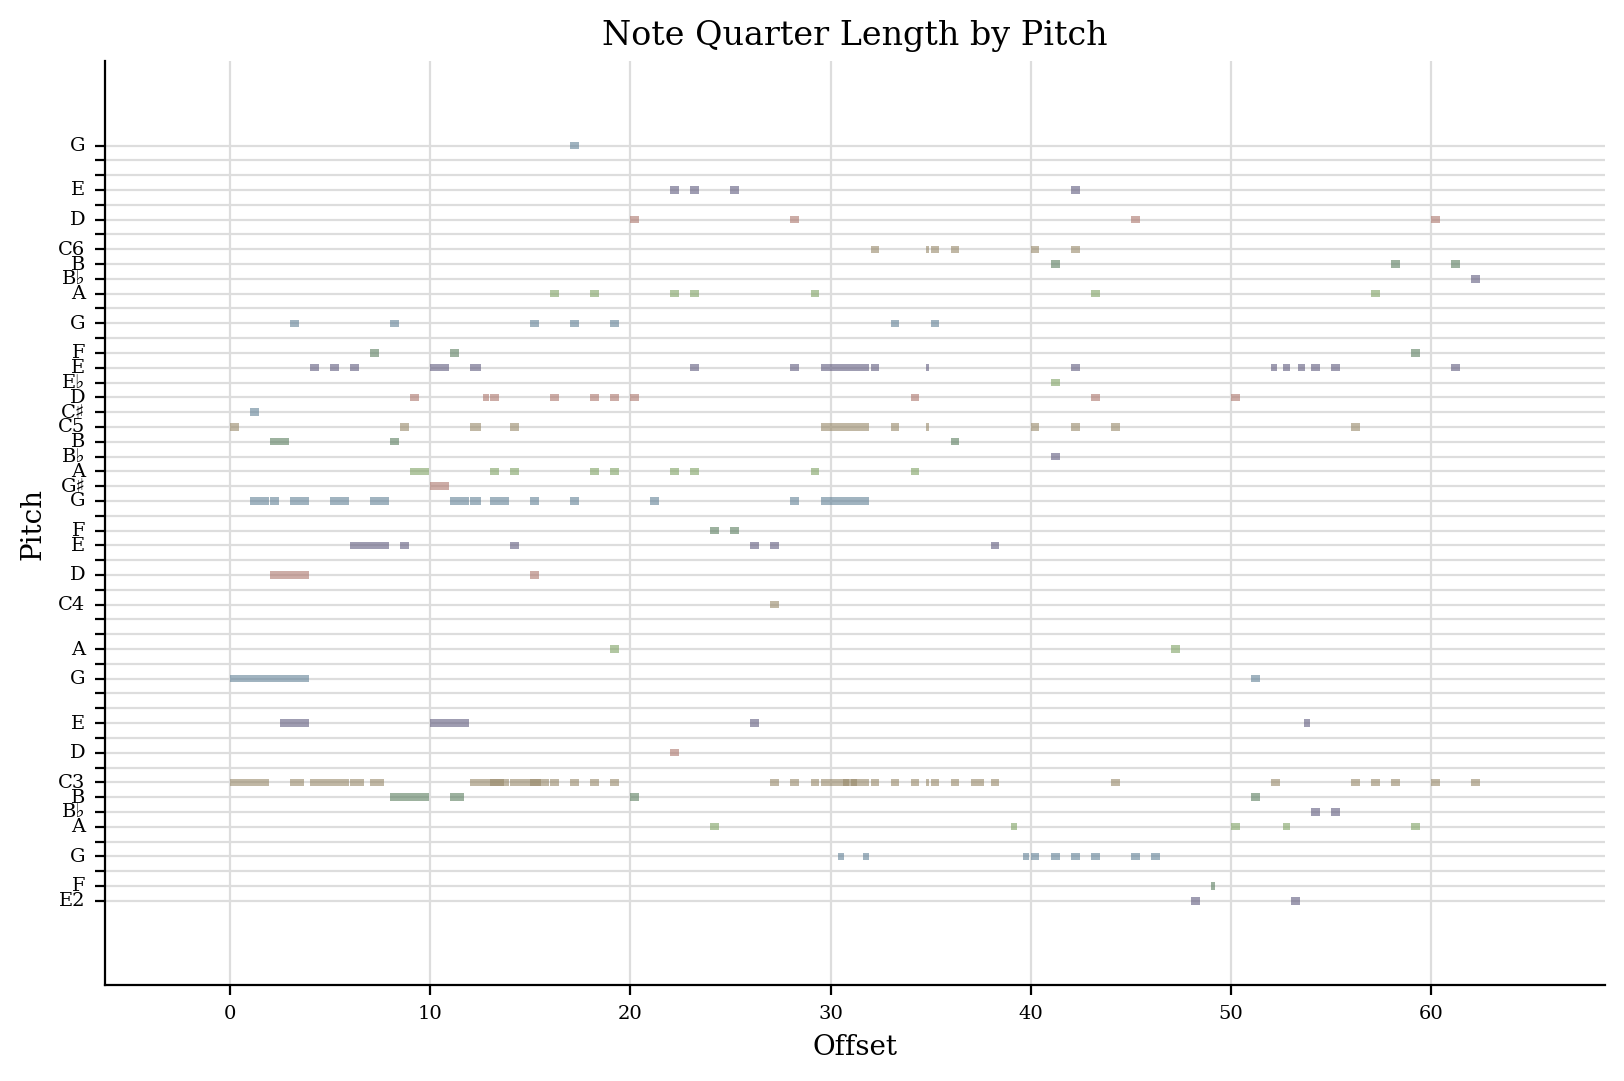

In [28]:
generated_stream = idx_to_stream_enc(np.array(score), vocab)
generated_stream.plot()

In [29]:
generated_stream.show('midi')

In [84]:
generated_stream.write('midi', '../data/midi/transformer_generated.mid')

'../data/midi/transformer_generated.mid'

Let's see if it can continue Animal Crossing

In [86]:
animal_crossing_midi_path = Path('../data/midi/vg_large/Animal Crossing_Nintendo 3DS_Animal Crossing New Leaf_100 AM.mid')
animal_crossing_idx_score = midifile_to_idx_score(animal_crossing_midi_path, vocab)
ac_intro = animal_crossing_idx_score[:128]
vocab.to_tokens(ac_intro[:, 0])

'<|sos|> <|sep|> d20 n68 d4 <|sep|> d4 n69 d4 <|sep|> d4 n71 d4 <|sep|> d4 n71 d24 n42 d5 <|sep|> d4 n49 d4 <|sep|> d4 n56 d8 <|sep|> d8 n47 d4 <|sep|> d4 n54 d4 <|sep|> d4 n63 d8 <|sep|> d4 n66 d4 <|sep|> d4 n66 d24 n52 d5 <|sep|> d4 n59 d4 <|sep|> d4 n63 d4 <|sep|> d4 n61 d4 <|sep|> d4 n68 d16 <|sep|> d12 n71 d4 <|sep|> d4 n71 d24 n42 d5 <|sep|> d4 n49 d4 <|sep|> d4 n56 d8 <|sep|> d8 n47 d4 <|sep|> d4 n54 d4 <|sep|> d4 n63 d8 <|sep|> d4 n66 d4 <|sep|> d4 n66 d24 n52 d5 <|sep|> d4 n59 d4 <|sep|> d4 n63 d4 <|sep|> d4 n61 d4 <|sep|> d4 n66 d16 <|sep|> d12 n71 d4 <|sep|> d4 n71'

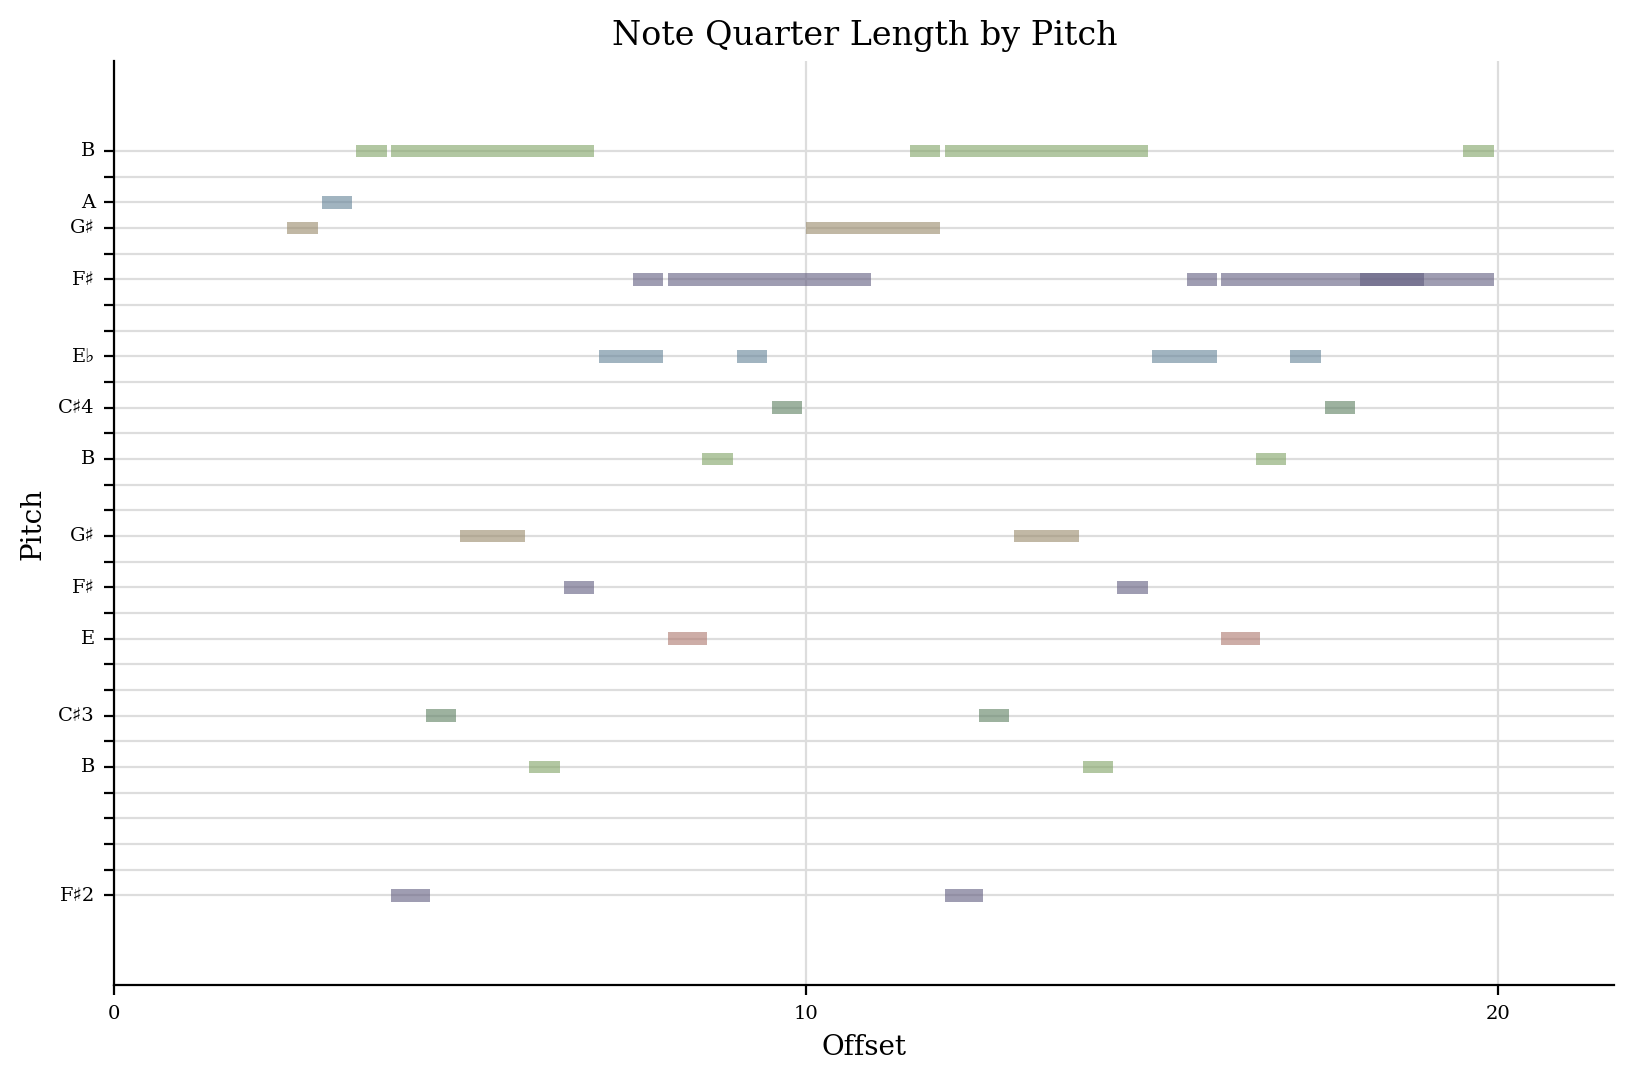

In [87]:
ac_intro_stream = idx_to_stream_enc(np.array(ac_intro[:, 0]), vocab)
ac_intro_stream.plot()

In [88]:
ac_intro_stream.show('midi')

In [90]:
ac_intro_stream.write('midi', '../data/midi/animal_crossing_intro.mid')

'../data/midi/animal_crossing_intro.mid'

In [93]:
ac_init = torch.tensor(ac_intro, device=device).unsqueeze(0)
ac_init.shape

torch.Size([1, 128, 2])

In [112]:
ac_continued = model.generate(ac_init, max_new_tokens=512).cpu()[0, :, 0]
vocab.to_tokens(ac_continued)

'<|sos|> <|sep|> d20 n68 d4 <|sep|> d4 n69 d4 <|sep|> d4 n71 d4 <|sep|> d4 n71 d24 n42 d5 <|sep|> d4 n49 d4 <|sep|> d4 n56 d8 <|sep|> d8 n47 d4 <|sep|> d4 n54 d4 <|sep|> d4 n63 d8 <|sep|> d4 n66 d4 <|sep|> d4 n66 d24 n52 d5 <|sep|> d4 n59 d4 <|sep|> d4 n63 d4 <|sep|> d4 n61 d4 <|sep|> d4 n68 d16 <|sep|> d12 n71 d4 <|sep|> d4 n71 d24 n42 d5 <|sep|> d4 n49 d4 <|sep|> d4 n56 d8 <|sep|> d8 n47 d4 <|sep|> d4 n54 d4 <|sep|> d4 n63 d8 <|sep|> d4 n66 d4 <|sep|> d4 n66 d24 n52 d5 <|sep|> d4 n59 d4 <|sep|> d4 n63 d4 <|sep|> d4 n61 d4 <|sep|> d4 n66 d16 <|sep|> d12 n71 d4 <|sep|> d4 n71 d24 n39 d5 <|sep|> d4 n66 d4 <|sep|> d4 n71 d4 n56 d8 <|sep|> d4 n63 d4 <|sep|> d4 n71 d16 n47 d4 <|sep|> d4 n56 d4 <|sep|> d4 n64 d8 n56 d8 <|sep|> d8 n68 d32 n39 d5 <|sep|> d4 n62 d4 <|sep|> d4 n63 d4 <|sep|> d4 n63 d4 <|sep|> d4 n68 d12 n40 d4 <|sep|> d4 n66 d4 <|sep|> d4 n68 d4 <|sep|> d4 n66 d4 <|sep|> d4 n60 d4 n57 d4 <|sep|> d4 n75 d4 <|sep|> d4 n68 d4 <|sep|> d4 n64 d4 <|sep|> d4 n72 d16 n47 d4 <|sep|> d4 

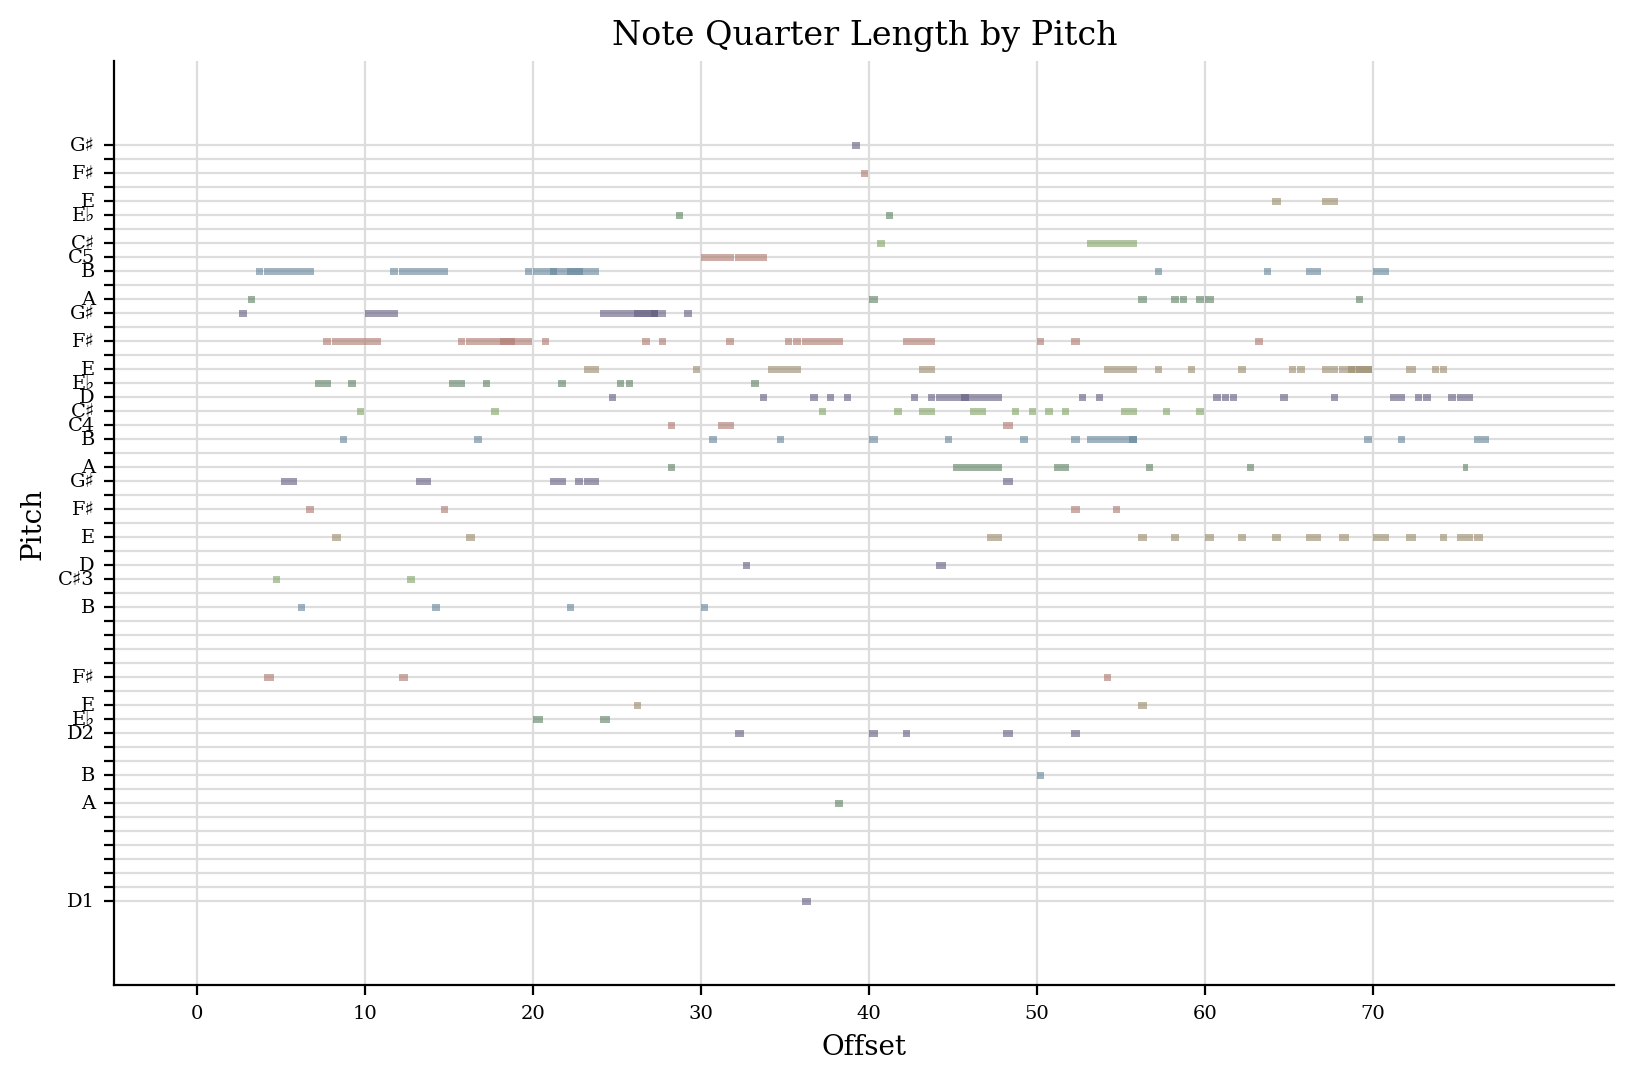

In [113]:
ac_continued_stream = idx_to_stream_enc(np.array(ac_continued), vocab)
ac_continued_stream.plot()

In [114]:
ac_continued_stream.show('midi')

In [116]:
ac_continued_stream.write('midi', '../data/midi/animal_crossing_continued.mid')

'../data/midi/animal_crossing_continued.mid'